Get thresholds for NEWMA

In [18]:
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb as nchoosek
from mmdew.fast_rbf_kernel import est_gamma
from mmdew.detectors import FastOKCUSUM
from tqdm import tqdm
import onlinecp.algos as algos
import onlinecp.utils.feature_functions as feat

In [2]:
B=50 # in line with our ScanB/OKCUSUM value

In [3]:
rng = np.random.default_rng()

In [4]:
d=20

In [5]:
ref_size=1000
reps=25
target_arl=15000
ref = rng.normal(size=(ref_size,d))

In [6]:
big_Lambda, small_lambda = algos.select_optimal_parameters(B)  # forget factors chosen with heuristic in the paper
thres_ff = small_lambda
# number of random features is set automatically with this criterion
m = int((1 / 4) / (small_lambda + big_Lambda) ** 2)
def feat_func(x):
    return feat.fourier_feat(x, W)

In [7]:
statistics = []

for _ in tqdm(range(reps)):
    ref = rng.normal(size=(ref_size,d))

    W, sigmasq = feat.generate_frequencies(m, d, data=ref[:500], choice_sigma="median")
    
    detector = algos.NEWMA(ref[0], forget_factor=big_Lambda, forget_factor2=small_lambda, feat_func=feat_func,
                       adapt_forget_factor=thres_ff)
    
    data = rng.normal(size=(target_arl*10,d))
    
    detector.apply_to_data(data)
    
    statistics += [s[0] for s in detector.stat_stored][400:] # remove noise

100%|███████████████████████████████████████████| 25/25 [02:57<00:00,  7.09s/it]


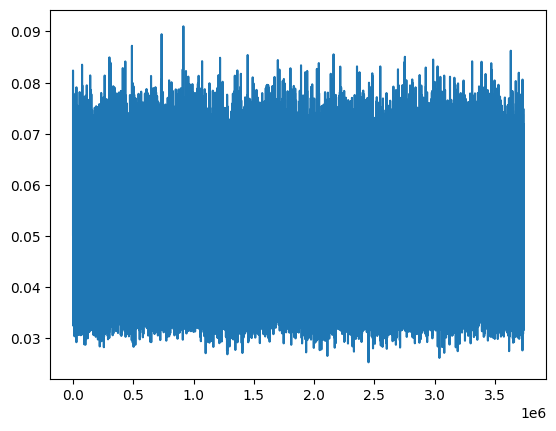

In [17]:
plt.plot(statistics)

In [9]:
import pickle

In [10]:
with open('newma-statistics.pickle', 'wb') as handle:
    pickle.dump(statistics, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open('newma-statistics.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [12]:
threshold = np.quantile(statistics, 1-(1/target_arl))

In [13]:
threshold

np.float64(0.07943296158180317)

In [14]:
threshold #somewhat lower than the one given in their article's Figure 3 but we also have lower values of the test statistic for Figure 1. Might be due to a slight difference in the median heuristic.

np.float64(0.07943296158180317)

In [15]:
target_arls_log = np.arange(3,5.1,.25)

arl2thresh = { i : np.quantile(statistics, 1-(1/10**i)) for i in target_arls_log}

In [16]:
arl2thresh

{np.float64(3.0): np.float64(0.07317716627632369),
 np.float64(3.25): np.float64(0.07459594113696043),
 np.float64(3.5): np.float64(0.07595820836179686),
 np.float64(3.75): np.float64(0.07741818850963111),
 np.float64(4.0): np.float64(0.07856788589699483),
 np.float64(4.25): np.float64(0.07981702196802444),
 np.float64(4.5): np.float64(0.08132243600124833),
 np.float64(4.75): np.float64(0.08254975454339335),
 np.float64(5.0): np.float64(0.08377287816773563)}